In [1]:
# Avoid warnings from libraries
import warnings
warnings.filterwarnings('ignore')

# Import libraries
from transformers import AutoProcessor, AutoTokenizer, CLIPModel
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import transformers
from transformers import AdamW, get_linear_schedule_with_warmup
import torch.nn.functional as F
from torch import nn

from PIL import Image

from tqdm import tqdm
import numpy as np
import pandas as pd
import torch
import random
import re
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import csv

In [2]:
# Setting the paths to all directories
parent_dir = # insert here the path of your parent dir
dataset_path = parent_dir + "data/split_data/"
models_dir = parent_dir + "models"
results_csv =  parent_dir + "results.csv"
text_aug_path = parent_dir + "data/text_augmentations/train_data_augmented.csv"

In [3]:
model_name =  "CLIP_large_aug_cross"

# Multimodal model parameters
MAX_LENGTH = 48
encoding_dimension = 512
dense_hidden_size = 128
pretraining = "openai/clip-vit-base-patch32"

fusion = "cross" # cross or concat

# General training
batch_size = 32
lr = 1e-5
n_epochs = 5
n_classes = 3
patience = 4 # Number of epochs to wait before early stopping

# Data augmentation
data_augmentation = True

image_augmentations = transforms.Compose([
    transforms.RandomRotation(degrees=40),
    transforms.RandomAffine(degrees=0, translate=(0.4, 0.4), scale=(0.7, 1.3), shear=0),
    transforms.RandomHorizontalFlip(p=0.0),
    transforms.RandomVerticalFlip(p=0.0),
    transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0),
    transforms.RandomPerspective(distortion_scale=0.5)
])

In [4]:
# Creating model directory
path = os.path.join(models_dir, model_name)
if not os.path.exists(path):
        os.mkdir(path)
results_path = models_dir+"/"+model_name+"/"

In [5]:
def get_random_seed_through_os():
    RAND_SIZE = 4
    random_data = os.urandom(
        RAND_SIZE
    )
    random_seed = int.from_bytes(random_data, byteorder="big")
    return random_seed

RANDOM_SEED = 123
# RANDOM_SEED = get_random_seed_through_os()
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

In [6]:
#Clean text and load the images names (as lists)
def clean_sentence(sentence, norm_user = True, norm_hashtag = True, separete_characters = True):
    # Convert instance to string
    sentence = str(sentence)

    # All text to lowecase
    sentence = sentence.lower()

    # Normalize users and url
    if norm_user == True:
        sentence = re.sub(r'\@\w+','@usuario', sentence)
    if norm_hashtag == True:
        sentence = re.sub(r"http\S+|www\S+|https\S+", 'url', sentence, flags=re.MULTILINE)

    # Separate special characters
    if separete_characters == True:
        sentence = re.sub(r":", " : ", sentence)
        sentence = re.sub(r",", " , ", sentence)
        sentence = re.sub(r"\.", " . ", sentence)
        sentence = re.sub(r"!", " ! ", sentence)
        sentence = re.sub(r"¡", " ¡ ", sentence)
        sentence = re.sub(r"“", " “ ", sentence)
        sentence = re.sub(r"'", " ' ", sentence)
        sentence = re.sub(r"”", " ” ", sentence)
        sentence = re.sub(r"\(", " ( ", sentence)
        sentence = re.sub(r"\)", " ) ", sentence)
        sentence = re.sub(r"\?", " ? ", sentence)
        sentence = re.sub(r"\¿", " ¿ ", sentence)

    # Substituting multiple spaces with single space
    sentence = re.sub(r'\s+', ' ', sentence, flags=re.I)

    return sentence

In [7]:
current_epoch = 1

# Defining the dataset class for loading the images and the associated text
class CustomDataset(Dataset):
    def __init__(self, image_folder, csv_file, mode):
        self.image_folder = image_folder
        self.data = pd.read_csv(csv_file)
        self.mode = mode
        if mode == "train" and data_augmentation:
            self.augmentations = pd.read_csv(text_aug_path)
        
        # Load text tokenizer and image processor
        self.tokenizer = AutoTokenizer.from_pretrained(pretraining)
        self.image_processor = AutoProcessor.from_pretrained(pretraining)

        self.label_encoder = LabelEncoder()
        self.data['encoded_labels'] = self.label_encoder.fit_transform(self.data['Label_1'])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        global current_epoch
        img_name = self.data.iloc[idx, 0]
        img_path = os.path.join(self.image_folder, img_name+ ".jpg")
        
        image = Image.open(img_path).convert('RGB')
        
        # Data augmenting
        if data_augmentation and self.mode == "train":
            image = image_augmentations(image)
            if current_epoch > 10:
                current_epoch = random.randint(1,10)
            sentence = clean_sentence(self.augmentations.loc[self.augmentations["IMG"] == img_name].iloc[0,current_epoch])
        
        else:
            sentence = clean_sentence(self.data.iloc[idx, 1])

        # Preprocess image according to CLIP
        inputs = self.image_processor(images=image, padding=True, return_tensors="pt")
        image = inputs["pixel_values"].squeeze(0)

        # Tokenize the text
        encoded_dict = self.tokenizer(sentence, padding='max_length', max_length=MAX_LENGTH, truncation=True, return_tensors="pt")
        input_ids = encoded_dict["input_ids"].squeeze(0)
        attention_mask = encoded_dict["attention_mask"].squeeze(0)

        encoded_label = self.data.iloc[idx, 4]
        label = torch.tensor(encoded_label, dtype=torch.long) # Label to tensor

        return image, input_ids, attention_mask, label

In [8]:
class EarlyFusion(nn.Module):
    def __init__(self, encoding_dimension, dense_hidden_size, n_classes, fusion):
        super(EarlyFusion, self).__init__()
        self.clip_model = CLIPModel.from_pretrained(pretraining)

        self.encoding_dimension = encoding_dimension
        self.dense_hidden_size = dense_hidden_size
        self.n_classes = n_classes
        
        self.fusion = fusion
        if self.fusion == "cross":
            self.features_dim = self.encoding_dimension**2
        elif self.fusion == "concat":
            self.features_dim = self.encoding_dimension*2

        self.layer_norm = nn.LayerNorm(self.features_dim)

        # MLP Classifier
        self.classifier = nn.Sequential(
            nn.Linear(self.features_dim, self.dense_hidden_size),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(self.dense_hidden_size, self.dense_hidden_size),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(self.dense_hidden_size, self.n_classes) 
        )

    def forward(self, image, input_ids, attention_mask):
        # Extract image and text features
        text_features = self.clip_model.get_text_features(input_ids=input_ids, attention_mask=attention_mask)
        image_features = self.clip_model.get_image_features(image)
        
        if self.fusion == "cross":
            features = torch.bmm(image_features.unsqueeze(2), text_features.unsqueeze(1))
            features = features.reshape(features.shape[0], -1) 
            norm_output = self.layer_norm(features)
        
        elif self.fusion == "concat":        
            concat_output = torch.cat((text_features, image_features), 1)
            norm_output = self.layer_norm(concat_output)
        
        out = self.classifier(norm_output)

        return out

In [9]:
# Loading images and text form the dataset
train_dataset = CustomDataset(dataset_path + "train_images", dataset_path + "train_data.csv", mode="train")
val_dataset = CustomDataset(dataset_path + "val_images", dataset_path + "validation_data.csv", mode="val")
test_dataset = CustomDataset(dataset_path + "test_images", dataset_path + "test_data.csv", mode="val")

# Defining data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Instantiating the multimodal model
multi_model = EarlyFusion(encoding_dimension, dense_hidden_size, n_classes, fusion)

# Train set up
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
multi_model.to(device)
optimizer = AdamW(multi_model.parameters(), lr)

# Define the number of training steps (epochs * number of batches)
total_steps = len(train_loader) * n_epochs
# Create a schedule for the LR update
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

# Uncomment for adding class weights
#-------------------------------------
# class_weights = compute_class_weight('balanced', classes=np.unique(train_dataset.data['encoded_labels']), y=train_dataset.data['encoded_labels'])
# print("Class weights: ", class_weights)
# class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
# criterion = nn.CrossEntropyLoss(weight=class_weights)

criterion = nn.CrossEntropyLoss()

In [10]:
#multi_model.load_state_dict(torch.load(results_path + "best_model.pt"))

train_hist = []
train_acc_hist = []  # List to store accuracy during training
val_hist = []
val_acc_hist = []  # List to store accuracy during validation
min_valid_loss = np.inf
counter = 0  # Counter for patience

multi_model.train()
for epoch in range(n_epochs):
    print(f"Epoch {epoch+1}/{n_epochs}")
    train_loss = []
    correct_train = 0
    total_train = 0

    for images, input_ids, attention_masks, labels in tqdm(train_loader):
        # Transfer Data to GPU
        images = images.to(device)
        input_ids = input_ids.to(device)
        attention_masks = attention_masks.to(device)
        labels = labels.to(device)

        # Clear gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = multi_model(images, input_ids, attention_masks)
        # Find the Loss
        loss = criterion(outputs, labels)
        # Calculate gradients
        loss.backward()
        # Prevent gradient explosion
        torch.nn.utils.clip_grad_norm_(multi_model.parameters(), 1)
        # Update Weights
        optimizer.step()
        # Calculate Loss
        train_loss.append(loss.item())

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    # Calculate average training loss
    avg_train_loss = torch.tensor(train_loss).mean()
    # Calculate training accuracy
    train_accuracy = correct_train / total_train
    print(f'Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}')
    train_hist.append(avg_train_loss.item())
    train_acc_hist.append(train_accuracy)

    # Validation
    multi_model.eval()
    valid_loss = []
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, input_ids, attention_masks, labels in val_loader:
            # Transfer Data to GPU
            images = images.to(device)
            input_ids = input_ids.to(device)
            attention_masks = attention_masks.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = multi_model(images, input_ids, attention_masks)
            # Find the Loss
            loss = criterion(outputs, labels)
            # Calculate Loss
            valid_loss.append(loss.item())

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    # Calculate average validation loss
    avg_valid_loss = torch.tensor(valid_loss).mean()
    # Calculate validation accuracy
    val_accuracy = correct_val / total_val
    print(f'Validation Loss: {avg_valid_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
    val_hist.append(avg_valid_loss.item())
    val_acc_hist.append(val_accuracy)

    # Early stopping
    if avg_valid_loss < min_valid_loss:
        min_valid_loss = avg_valid_loss
        counter = 0  # Reset counter if validation loss decreases
        # Save the model if validation loss improved
        torch.save(multi_model.state_dict(), results_path + "best_model.pt")
    else:
        counter += 1  # Increment counter if validation loss does not decrease

    if counter >= patience:
        print(f'Early stopping at epoch {epoch+1} as validation loss did not improve for {patience} epochs.')
        break
    current_epoch +=1

Epoch 1/5


  0%|          | 0/93 [00:00<?, ?it/s]

torch.Size([32, 512])
torch.Size([32, 512])


  2%|▏         | 2/93 [00:01<01:26,  1.05it/s]

torch.Size([32, 512])
torch.Size([32, 512])


  3%|▎         | 3/93 [00:02<01:24,  1.07it/s]

torch.Size([32, 512])
torch.Size([32, 512])


  4%|▍         | 4/93 [00:03<01:26,  1.03it/s]

torch.Size([32, 512])
torch.Size([32, 512])


  5%|▌         | 5/93 [00:04<01:19,  1.11it/s]

torch.Size([32, 512])
torch.Size([32, 512])


  5%|▌         | 5/93 [00:05<01:32,  1.05s/it]


KeyboardInterrupt: 

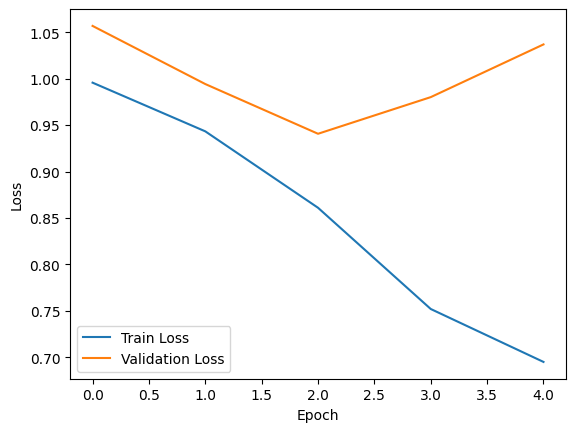

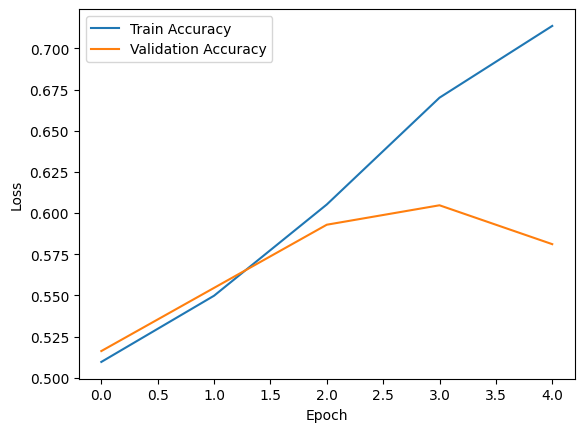

In [ ]:
# Plot the training and validation losses
plt.plot(train_hist, label="Train Loss")
plt.plot(val_hist, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig(results_path+"loss_graph.png")
plt.show()

# Plot the training and validation accuracy
plt.plot(train_acc_hist, label="Train Accuracy")
plt.plot(val_acc_hist, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig(results_path+"accuracy_graph.png")
plt.show()


In [ ]:
# Función para calcular las métricas de clasificación
def calculate_metrics(true_labels, predicted_labels):
    report = classification_report(true_labels, predicted_labels)
    print(report)
    # se guarda el classification report
    with open(results_path+'classification_report.txt', 'w') as f:
        f.write(report)
    f.close()

    cm = confusion_matrix(true_labels, predicted_labels)
    print("Confusion Matrix:")
    print(cm)
    # se guarda la matriz de confusion
    np.savetxt(results_path +'matrizConf_cnn.txt', cm, fmt='%-3d')

    # almacenamos una imagen de la matriz de confusion
    labels = test_loader.dataset.label_encoder.inverse_transform(list(range(cm.shape[0])))
    ig, axis = plt.subplots(figsize=(8, 8))
    im = axis.imshow(cm, interpolation='nearest', cmap=plt.cm.Purples)

    axis.set(xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        xticklabels=labels, yticklabels=labels,
        xlabel='Real', ylabel='Predicción')

    axis.set_xticklabels(labels, fontsize=10)
    axis.set_yticklabels(labels, fontsize=10)

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            axis.text(j, i, format(cm[i, j], 'd'),ha='center', va='center', color='white' if cm[i, j] > cm.max()/2 else 'black')

    plt.savefig(results_path+'confusion_matrix.png', bbox_inches='tight')

              precision    recall  f1-score   support

           0       0.44      0.35      0.39        55
           1       0.40      0.22      0.29        76
           2       0.71      0.86      0.78       209

    accuracy                           0.64       340
   macro avg       0.52      0.48      0.48       340
weighted avg       0.60      0.64      0.60       340

Confusion Matrix:
[[ 19  11  25]
 [  9  17  50]
 [ 15  14 180]]


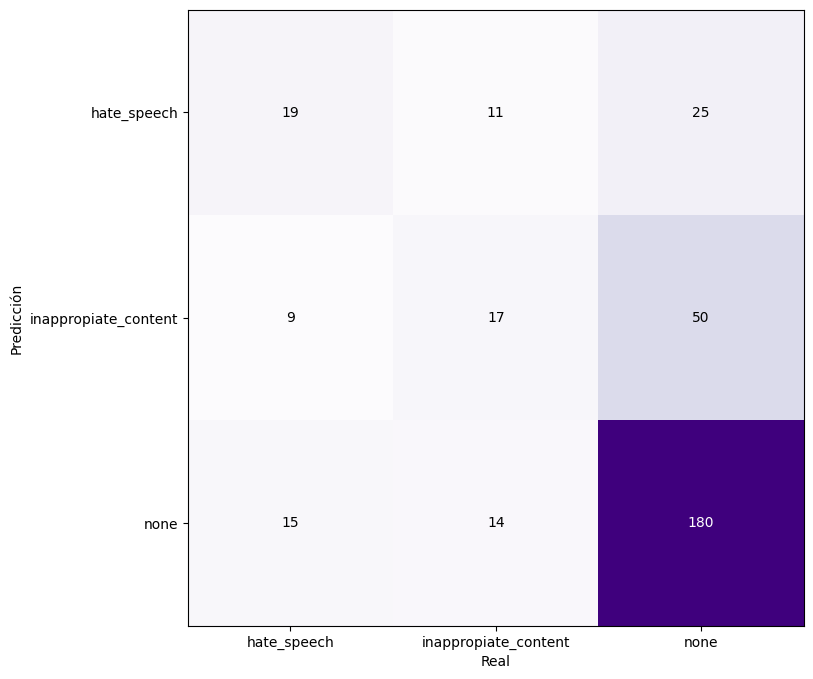

In [ ]:
# Evaluación del modelo en el conjunto de prueba
test_predictions = []
test_true_labels = []

# recover model best state
multi_model.load_state_dict(torch.load(results_path + "best_model.pt"))

# Initialize test metrics
test_loss = 0.0
correct_test = 0
total_test = 0

with torch.no_grad():
      for images, input_ids, attention_masks, labels in test_loader:
        images = images.to(device)
        input_ids = input_ids.to(device)
        attention_masks = attention_masks.to(device)
        labels = labels.to(device)

        outputs = multi_model(images, input_ids, attention_masks)
        test_loss += criterion(outputs, labels).item()
        _, predicted = torch.max(outputs, 1)

        correct_test += (predicted == labels).sum().item()
        total_test += labels.size(0)

        test_predictions.extend(predicted.cpu().numpy())
        test_true_labels.extend(labels.cpu().numpy())
        
# Average test loss
avg_test_loss = test_loss / len(test_loader)
# Test accuracy
test_accuracy = correct_test / total_test

# Calcular métricas de evaluación en el conjunto de prueba
calculate_metrics(test_true_labels, test_predictions)

# Record all the results into a csv
best_epoch = val_hist.index(min(val_hist)) + 1 # best val epoch
with open(results_csv, mode='a', newline='') as file:
    writer = csv.writer(file)
    writer.writerow([model_name, train_hist[best_epoch-1], train_acc_hist[best_epoch-1], val_hist[best_epoch-1], val_acc_hist[best_epoch-1], avg_test_loss, test_accuracy, best_epoch])
